In [9]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


In [10]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
# Create output directories if they don't exist
os.makedirs('data', exist_ok=True)
os.makedirs('visualizations', exist_ok=True)
os.makedirs('models', exist_ok=True)

# Set plotting style
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.2)

In [12]:

print("===== STEAM GAME RECOMMENDATION SYSTEM TRAINING =====")
print("Loading and exploring data...")

===== STEAM GAME RECOMMENDATION SYSTEM TRAINING =====
Loading and exploring data...


In [13]:
# Load the scraped data
df = pd.read_pickle('data_backup/game_data.pkl')

In [14]:
# Data preprocessing
print(f"Original data shape: {df.shape}")
print(f"Original columns: {df.columns.tolist()}")

Original data shape: (100, 9)
Original columns: ['AppID', 'Name', 'About', 'ReleaseDate', 'Developer', 'Tags', 'HeaderImage', 'Price', 'Reviews']


In [15]:
# Display basic stats
print("\nData overview:")
print(df.info())


Data overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   AppID        100 non-null    object
 1   Name         100 non-null    object
 2   About        100 non-null    object
 3   ReleaseDate  100 non-null    object
 4   Developer    100 non-null    object
 5   Tags         100 non-null    object
 6   HeaderImage  100 non-null    object
 7   Price        100 non-null    object
 8   Reviews      100 non-null    object
dtypes: object(9)
memory usage: 7.2+ KB
None


In [16]:
# Remove rows with errors or missing crucial data
df = df[~df['Name'].str.contains('Error')]
print(f"\nAfter removing error rows: {df.shape}")


After removing error rows: (100, 9)


In [17]:

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values by column:")
print(missing_values)



Missing values by column:
AppID          0
Name           0
About          0
ReleaseDate    0
Developer      0
Tags           0
HeaderImage    0
Price          0
Reviews        0
dtype: int64


In [18]:

# Fill missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('')
    else:
        df[col] = df[col].fillna(0)


In [19]:

# Basic data exploration visualizations
print("\nCreating data visualizations...")


Creating data visualizations...


In [20]:
# 1. Top 20 tags distribution
plt.figure(figsize=(12, 8))
tag_counts = {}
for tags_str in df['Tags']:
    if isinstance(tags_str, str) and tags_str:
        for tag in tags_str.split(','):
            tag = tag.strip()
            tag_counts[tag] = tag_counts.get(tag, 0) + 1

<Figure size 1200x800 with 0 Axes>

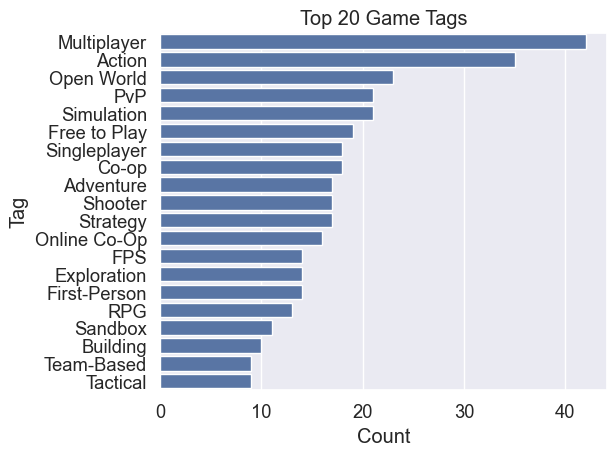

In [21]:
# Sort and plot top 20 tags
tag_df = pd.DataFrame({'Tag': list(tag_counts.keys()), 'Count': list(tag_counts.values())})
tag_df = tag_df.sort_values('Count', ascending=False).head(20)
sns.barplot(x='Count', y='Tag', data=tag_df)
plt.title('Top 20 Game Tags')
plt.tight_layout()
plt.savefig('visualizations/top_tags.png')


Generating word cloud of game descriptions...


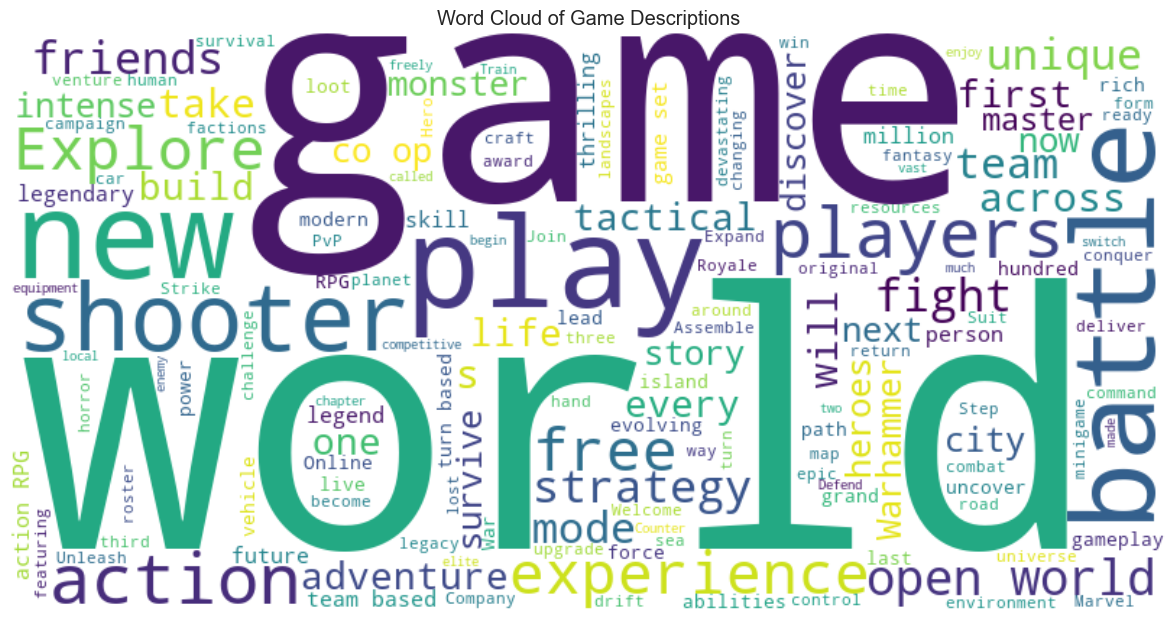

In [22]:
# 2. Word cloud of game descriptions
print("Generating word cloud of game descriptions...")
text = ' '.join(df['About'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=150).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Game Descriptions')
plt.tight_layout()
plt.savefig('visualizations/description_wordcloud.png')

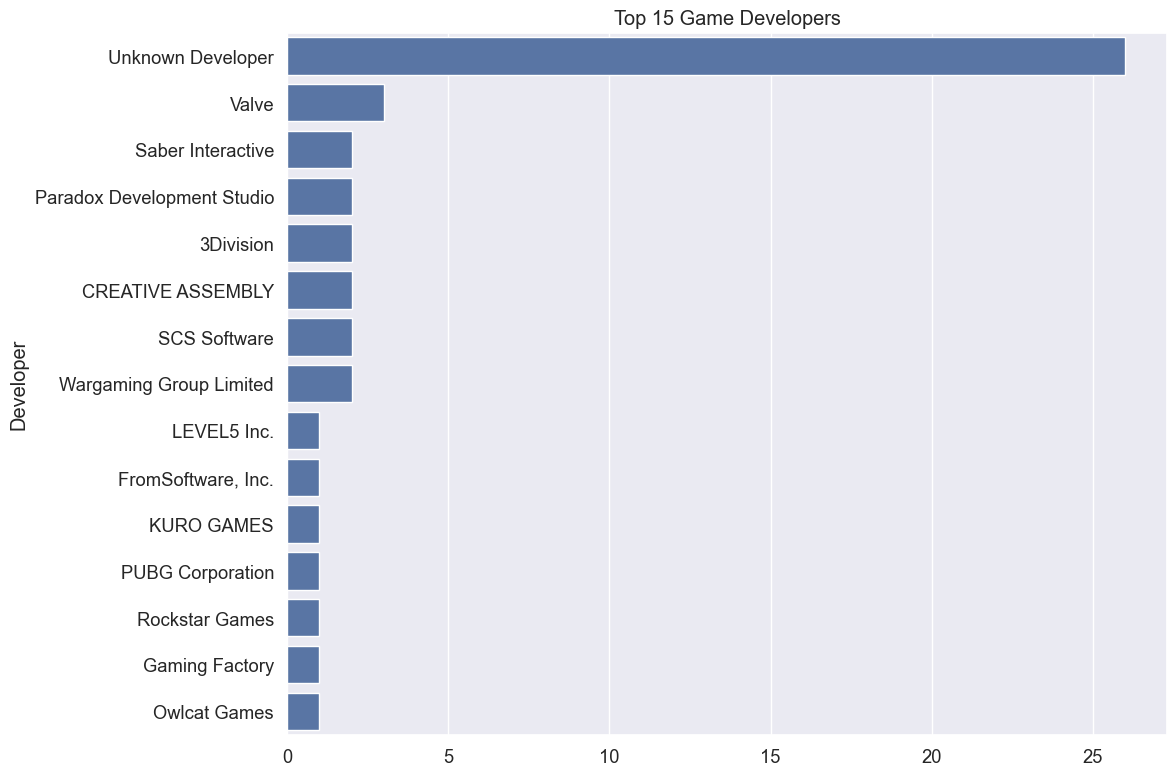

In [23]:

# 3. Developers distribution
plt.figure(figsize=(12, 8))
top_devs = df['Developer'].value_counts().head(15)
sns.barplot(x=top_devs.values, y=top_devs.index)
plt.title('Top 15 Game Developers')
plt.tight_layout()
plt.savefig('visualizations/top_developers.png')


In [24]:

# Feature Engineering
print("\nPerforming feature engineering...")



Performing feature engineering...


In [25]:
# Create a combined text feature for similarity calculation
df['combined_features'] = df['Name'] + ' ' + df['About'] + ' ' + df['Developer'] + ' ' + df['Tags']


In [26]:
# Create TF-IDF vectors from the combined features
print("Creating TF-IDF vectors...")
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(df['combined_features'])
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

Creating TF-IDF vectors...
TF-IDF matrix shape: (100, 1236)


In [27]:
# Save the TF-IDF vectorizer
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

In [28]:
# Calculate the cosine similarity matrix
print("Calculating cosine similarity matrix...")
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(f"Cosine similarity matrix shape: {cosine_sim.shape}")#

Calculating cosine similarity matrix...
Cosine similarity matrix shape: (100, 100)


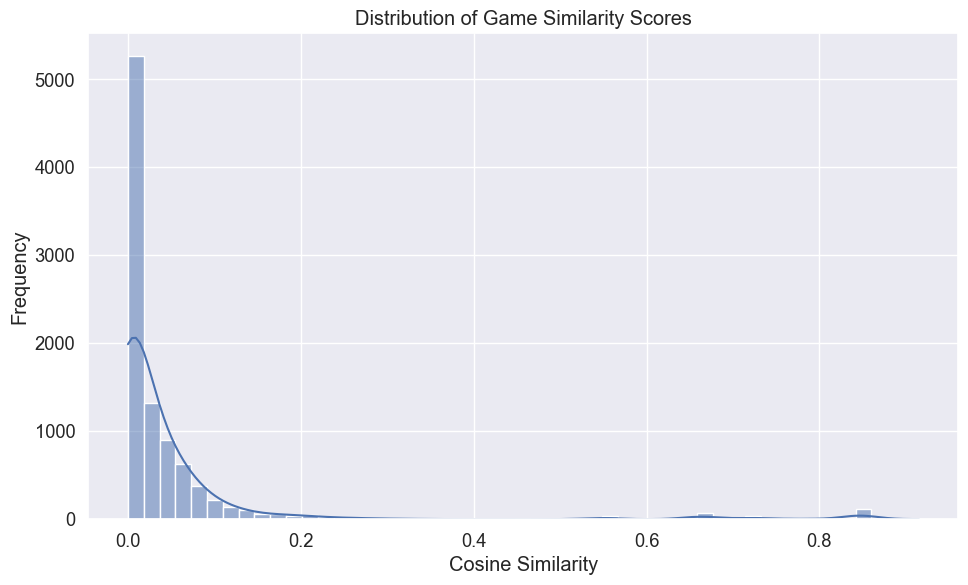

In [29]:
# Save similarity distribution histogram
plt.figure(figsize=(10, 6))
# Flatten the similarity matrix and remove self-similarities (which are always 1.0)
similarities = cosine_sim.flatten()
similarities = similarities[similarities < 0.999]  # Remove self-similarities
sns.histplot(similarities, bins=50, kde=True)
plt.title('Distribution of Game Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.savefig('visualizations/similarity_distribution.png')

In [30]:
# Clustering games based on features
print("\nClustering games...")

# Use PCA to reduce dimensions before clustering
pca = PCA(n_components=50)
game_features_reduced = pca.fit_transform(tfidf_matrix.toarray())

# Save the PCA model
with open('models/pca_model.pkl', 'wb') as f:
    pickle.dump(pca, f)



Clustering games...


In [31]:
# Find optimal number of clusters using the elbow method
wcss = []
max_clusters = 15  # Try up to 15 clusters
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(game_features_reduced)
    wcss.append(kmeans.inertia_)


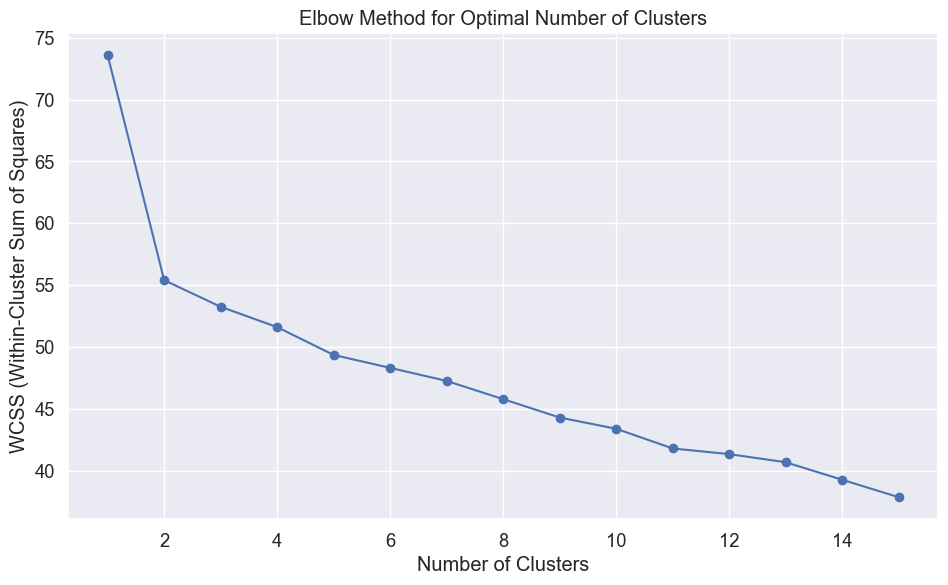

In [32]:
# Plot the elbow method results
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.savefig('visualizations/elbow_method.png')

In [33]:
# Choose number of clusters based on elbow method (this is an approximation)
# In a real scenario, you might want to manually inspect the plot and choose
optimal_clusters = 8  # This is a simplified approach

print(f"Training KMeans with {optimal_clusters} clusters...")
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(game_features_reduced)

# Save the KMeans model
with open('models/kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

Training KMeans with 8 clusters...


In [34]:
# Visualize clusters with t-SNE
print("Visualizing clusters with t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(game_features_reduced)


Visualizing clusters with t-SNE...


In [35]:
# Create a DataFrame for visualization
tsne_df = pd.DataFrame({
    'x': tsne_results[:, 0],
    'y': tsne_results[:, 1],
    'cluster': df['cluster'],
    'game': df['Name']
})

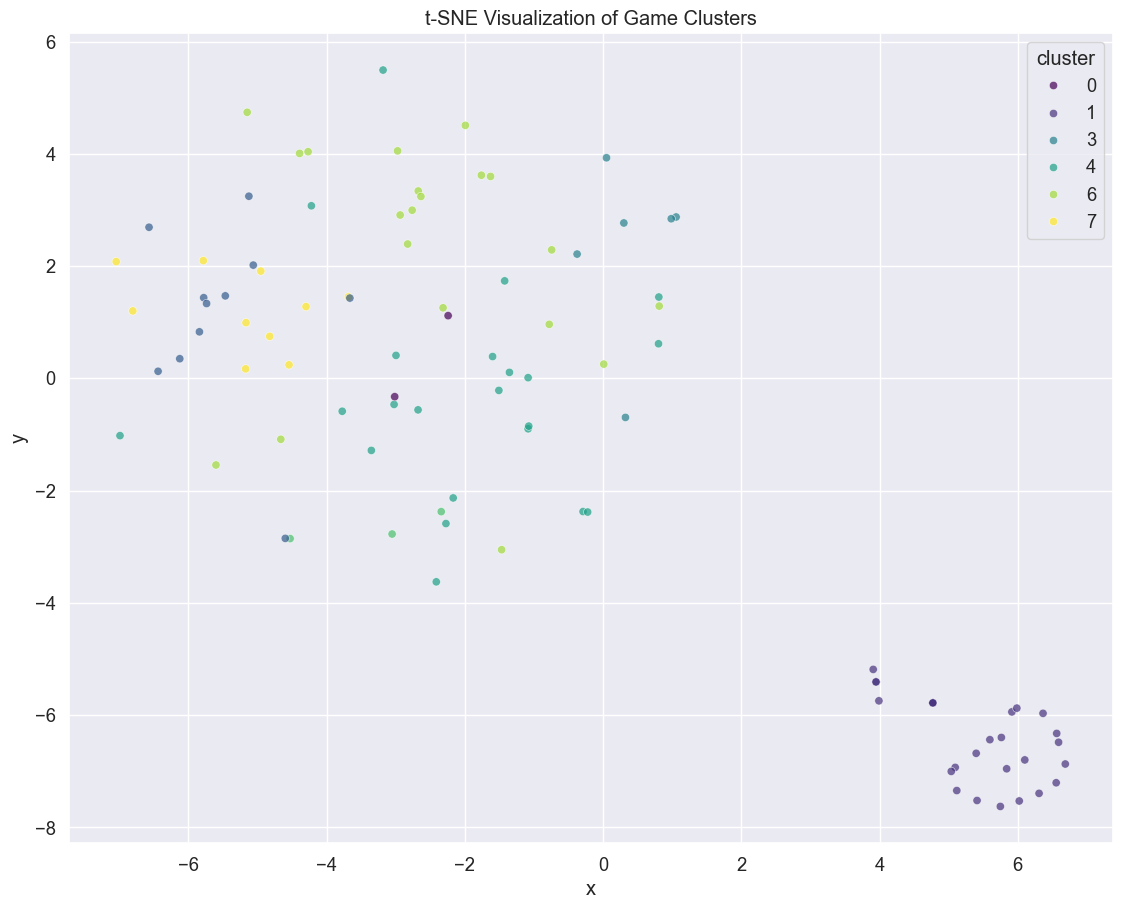

In [36]:
# Plot t-SNE results
plt.figure(figsize=(12, 10))
sns.scatterplot(x='x', y='y', hue='cluster', data=tsne_df, palette='viridis', alpha=0.7)
plt.title('t-SNE Visualization of Game Clusters')
plt.savefig('visualizations/tsne_clusters.png')


Analyzing game clusters...


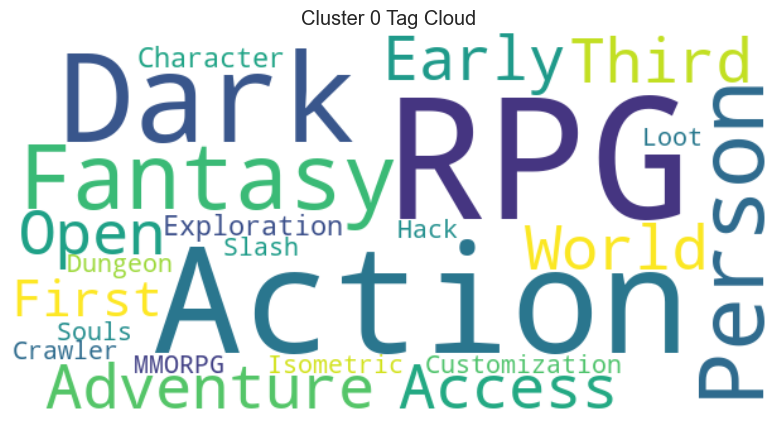

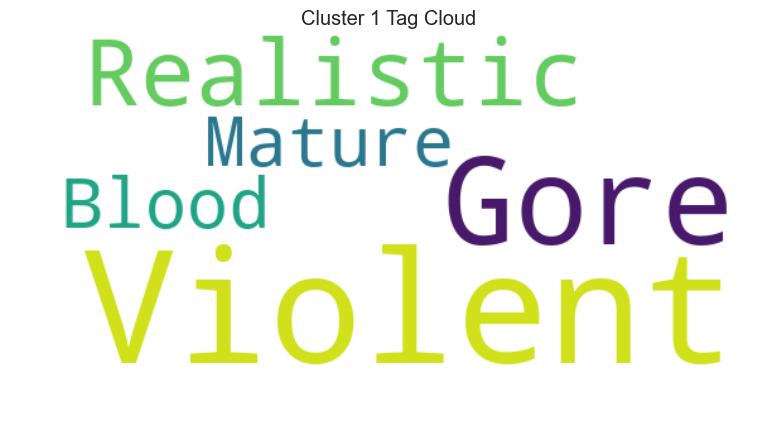

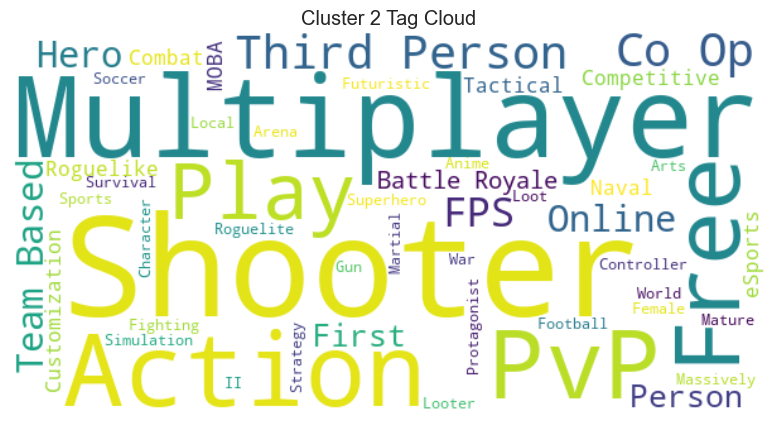

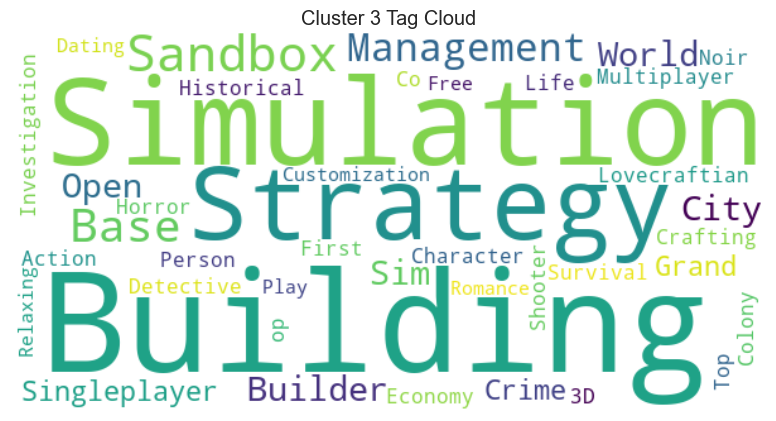

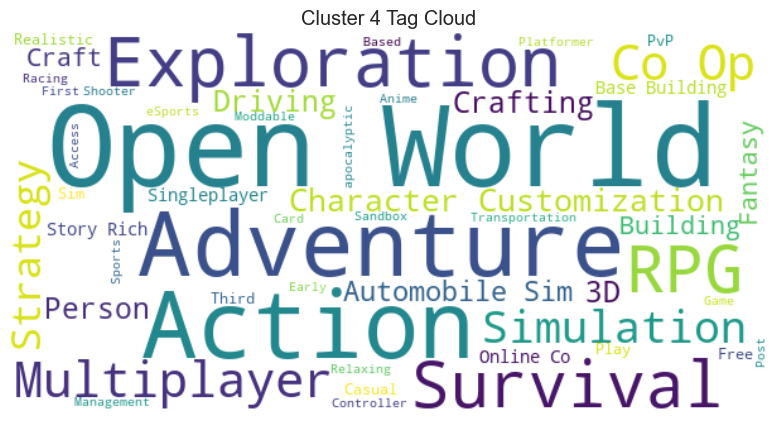

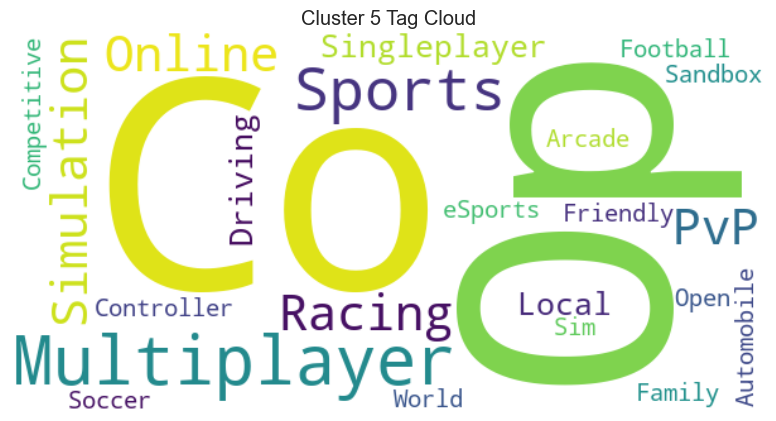

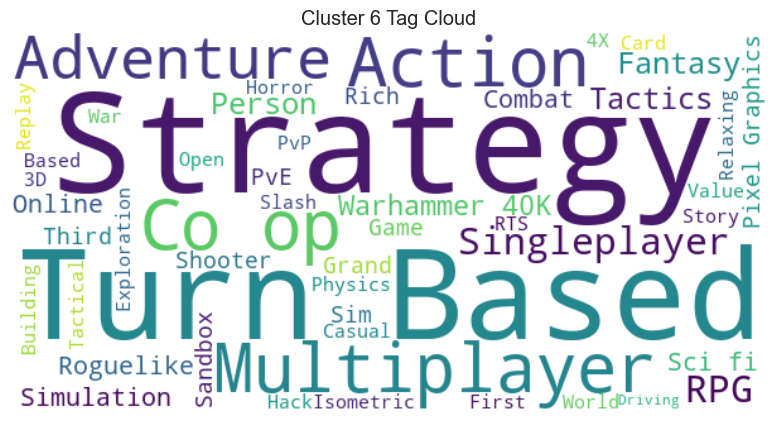

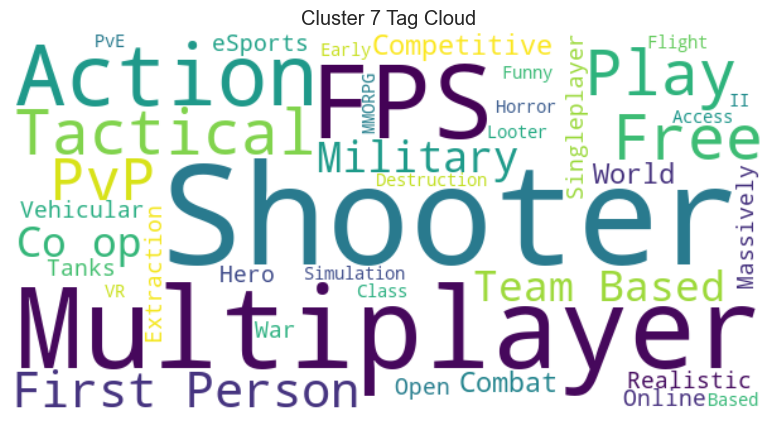

In [37]:
# Analyze clusters
print("\nAnalyzing game clusters...")
cluster_analysis = df.groupby('cluster')['Tags'].apply(lambda x: ' '.join(x)).reset_index()

for i, row in cluster_analysis.iterrows():
    cluster_id = row['cluster']
    tags = row['Tags']
    
    # Generate word cloud for each cluster
    plt.figure(figsize=(8, 6))
    wordcloud = WordCloud(width=600, height=300, background_color='white', max_words=50).generate(tags)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {cluster_id} Tag Cloud')
    plt.tight_layout()
    plt.savefig(f'visualizations/cluster_{cluster_id}_tags.png')

In [38]:
# Add cluster information to the dataframe
df_with_clusters = df.copy()

# Save the cleaned and processed dataframe
print("\nSaving processed data...")
df.to_pickle('data/cleaned_games.pkl')



Saving processed data...


In [39]:
# Save the similarity matrix
with open('data/similarity.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)


In [40]:
# Create a test sample recommendation function
def get_recommendations(game_title, df=df, cosine_sim=cosine_sim):
    idx = df[df['Name'] == game_title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    game_indices = [i[0] for i in sim_scores]
    return df['Name'].iloc[game_indices], [sim_scores[i][1] for i in range(len(sim_scores))]


In [41]:

# Test recommendations for a few popular games
print("\nGenerating sample recommendations:")
sample_games = df['Name'].iloc[:5].tolist()
for game in sample_games:
    recommendations, scores = get_recommendations(game)
    print(f"\nRecommendations for {game}:")
    for i, (rec, score) in enumerate(zip(recommendations, scores)):
        print(f"{i+1}. {rec} (Similarity: {score:.4f})")


Generating sample recommendations:

Recommendations for Counter-Strike 2:
1. Tom Clancy's Rainbow Six® Siege (Similarity: 0.1746)
2. Strinova (Similarity: 0.1536)
3. Dota 2 (Similarity: 0.1393)
4. Team Fortress 2 (Similarity: 0.1353)
5. Overwatch® 2 (Similarity: 0.1298)
6. THE FINALS (Similarity: 0.1141)
7. Marvel Rivals (Similarity: 0.1114)
8. Delta Force (Similarity: 0.1081)
9. World of Tanks (Similarity: 0.1009)
10. Ready or Not (Similarity: 0.0910)

Recommendations for FANTASY LIFE i: The Girl Who Steals Time:
1. Hogwarts Legacy (Similarity: 0.1826)
2. Tainted Grail: The Fall of Avalon (Similarity: 0.1723)
3. Enshrouded (Similarity: 0.1443)
4. Black Desert (Similarity: 0.1405)
5. The Sims™ 4 (Similarity: 0.1287)
6. Cauldron (Similarity: 0.1259)
7. Total War: WARHAMMER II (Similarity: 0.1204)
8. Last Epoch (Similarity: 0.1197)
9. MOBILE SUIT GUNDAM SEED BATTLE DESTINY REMASTERED (Similarity: 0.1186)
10. Stardew Valley (Similarity: 0.1175)

Recommendations for Unknown Title:
1. Unkn


===== RECOMMENDATION SYSTEM ACCURACY EVALUATION =====

Evaluating recommendation accuracy using different k values:
K	Precision	Recall		F1 Score	NDCG
------------------------------------------------------------
5	0.6420		0.2400		0.3040		0.6647
10	0.5960		0.3940		0.4282		0.6507
15	0.5500		0.5253		0.4914		0.6536
20	0.5210		0.6369		0.5314		0.6582


===== CONTENT-BASED RECOMMENDATION QUALITY ASSESSMENT =====
Tag overlap between games and their recommendations:
Game					Tag Overlap
------------------------------------------------------------
Total War: WARHAMMER II       	0.1830
Delta Force                   	0.3284
The Crew Motorfest            	0.2045
Enshrouded                    	0.2515
Dota 2                        	0.2726
Destiny 2                     	0.2547
Schedule I                    	0.2289
World of Warships             	0.2077
ELDEN RING NIGHTREIGN         	0.2095
Counter-Strike 2              	0.4381

Average tag overlap: 0.2579

Developer consistency in recommendations:
Game

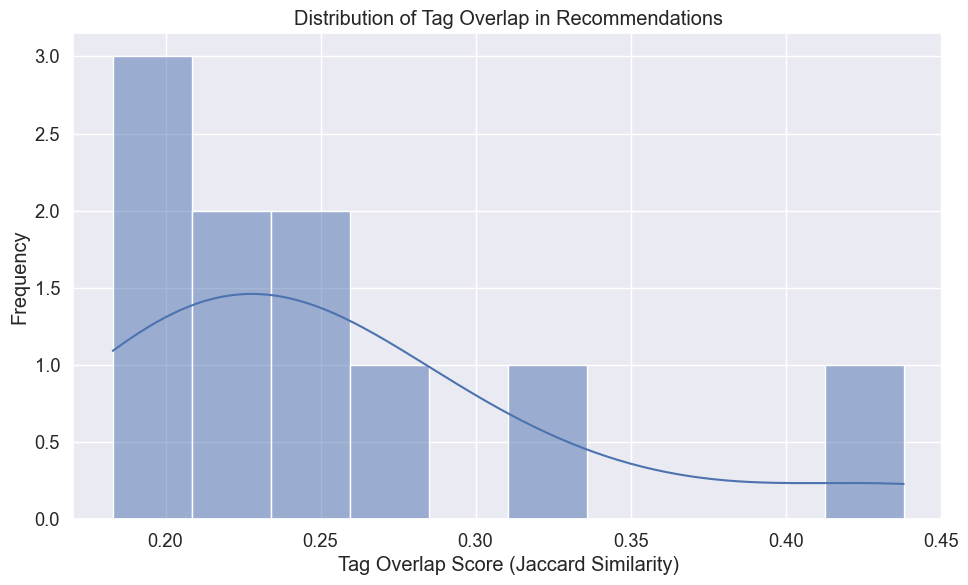

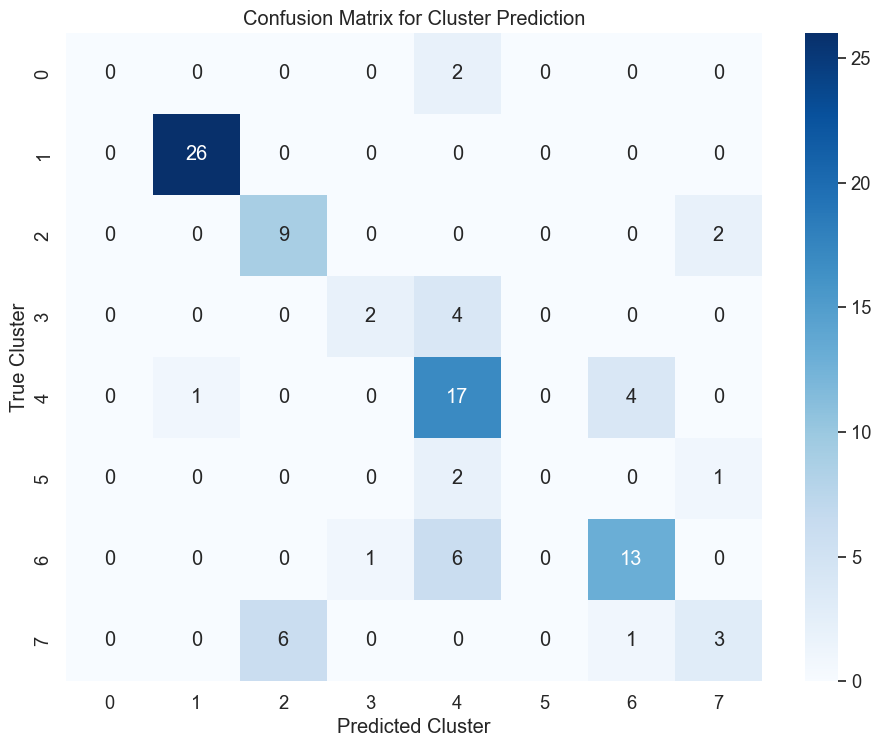

In [42]:
# Add this after your sample recommendations section (cell 34)

# Accuracy Evaluation for Recommendation System
print("\n===== RECOMMENDATION SYSTEM ACCURACY EVALUATION =====")

# 1. Cross-validation approach for recommendation systems
from sklearn.model_selection import KFold
import numpy as np

def evaluate_recommendations(df, cosine_sim, k=10, n_splits=5):
    """
    Evaluate recommendation accuracy using cross-validation
    
    Parameters:
    - df: DataFrame with game data
    - cosine_sim: Similarity matrix
    - k: Number of recommendations to generate
    - n_splits: Number of splits for cross-validation
    
    Returns:
    - Average precision@k, recall@k, and F1 score
    """
    # Create cross-validation splits
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Store metrics for each fold
    precision_scores = []
    recall_scores = []
    f1_scores = []
    ndcg_scores = []
    
    # For each game, we'll consider games in the same cluster as relevant
    clusters = df['cluster'].values
    
    # Get indices for each split
    indices = np.arange(len(df))
    
    for train_idx, test_idx in kf.split(indices):
        # For each test game
        for idx in test_idx:
            game_title = df.iloc[idx]['Name']
            actual_cluster = df.iloc[idx]['cluster']
            
            # Find relevant games (same cluster) excluding the game itself
            relevant_indices = set(df[df['cluster'] == actual_cluster].index) - {idx}
            
            # Get top-k recommendations
            sim_scores = list(enumerate(cosine_sim[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            sim_scores = sim_scores[1:k+1]  # Skip the first one (the game itself)
            rec_indices = [i[0] for i in sim_scores]
            
            # Calculate precision and recall
            relevant_recs = set(rec_indices).intersection(relevant_indices)
            
            if len(rec_indices) > 0:
                precision = len(relevant_recs) / len(rec_indices)
            else:
                precision = 0
                
            if len(relevant_indices) > 0:
                recall = len(relevant_recs) / len(relevant_indices)
            else:
                recall = 0
                
            # Calculate F1 score
            if precision + recall > 0:
                f1 = 2 * (precision * recall) / (precision + recall)
            else:
                f1 = 0
                
            # Calculate NDCG (Normalized Discounted Cumulative Gain)
            dcg = 0
            idcg = 0
            
            # Calculate DCG
            for i, rec_idx in enumerate(rec_indices):
                rel = 1 if rec_idx in relevant_indices else 0
                dcg += rel / np.log2(i + 2)  # i+2 because i starts from 0
                
            # Calculate IDCG
            relevant_count = min(len(relevant_indices), k)
            for i in range(relevant_count):
                idcg += 1 / np.log2(i + 2)
                
            ndcg = dcg / idcg if idcg > 0 else 0
            
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)
            ndcg_scores.append(ndcg)
    
    # Calculate averages
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    avg_ndcg = np.mean(ndcg_scores)
    
    return avg_precision, avg_recall, avg_f1, avg_ndcg

# Run evaluation
k_values = [5, 10, 15, 20]
print("\nEvaluating recommendation accuracy using different k values:")
print("K\tPrecision\tRecall\t\tF1 Score\tNDCG")
print("-" * 60)

for k in k_values:
    precision, recall, f1, ndcg = evaluate_recommendations(df, cosine_sim, k=k)
    print(f"{k}\t{precision:.4f}\t\t{recall:.4f}\t\t{f1:.4f}\t\t{ndcg:.4f}")

# 2. Content-based recommendation quality assessment
print("\n\n===== CONTENT-BASED RECOMMENDATION QUALITY ASSESSMENT =====")

# Calculate tag overlap between games and their recommendations
def calculate_tag_overlap(game_title, recommendations, df):
    """Calculate the percentage of tags shared between a game and its recommendations"""
    game_tags = set(df[df['Name'] == game_title]['Tags'].iloc[0].split(','))
    game_tags = {tag.strip() for tag in game_tags}
    
    overlap_scores = []
    for rec in recommendations:
        rec_tags = set(df[df['Name'] == rec]['Tags'].iloc[0].split(','))
        rec_tags = {tag.strip() for tag in rec_tags}
        
        # Calculate Jaccard similarity
        if len(game_tags.union(rec_tags)) > 0:
            overlap = len(game_tags.intersection(rec_tags)) / len(game_tags.union(rec_tags))
        else:
            overlap = 0
            
        overlap_scores.append(overlap)
    
    return np.mean(overlap_scores)

# Select random games to evaluate
np.random.seed(42)
eval_games = np.random.choice(df['Name'].values, size=10, replace=False)

print("Tag overlap between games and their recommendations:")
print("Game\t\t\t\t\tTag Overlap")
print("-" * 60)

tag_overlaps = []
for game in eval_games:
    recommendations, _ = get_recommendations(game)
    overlap = calculate_tag_overlap(game, recommendations, df)
    tag_overlaps.append(overlap)
    
    # Format game name for display
    display_name = game[:30] + "..." if len(game) > 30 else game.ljust(30)
    print(f"{display_name}\t{overlap:.4f}")

print(f"\nAverage tag overlap: {np.mean(tag_overlaps):.4f}")

# 3. Visualize recommendation quality
plt.figure(figsize=(10, 6))
sns.histplot(tag_overlaps, bins=10, kde=True)
plt.title('Distribution of Tag Overlap in Recommendations')
plt.xlabel('Tag Overlap Score (Jaccard Similarity)')
plt.ylabel('Frequency')
plt.savefig('visualizations/recommendation_quality.png')

# 4. Developer consistency in recommendations
def calculate_developer_consistency(game_title, recommendations, df):
    """Check if recommendations include games from the same developer"""
    game_dev = df[df['Name'] == game_title]['Developer'].iloc[0]
    rec_devs = [df[df['Name'] == rec]['Developer'].iloc[0] for rec in recommendations]
    
    # Count recommendations from the same developer
    same_dev_count = sum(1 for dev in rec_devs if dev == game_dev)
    
    return same_dev_count / len(recommendations)

print("\nDeveloper consistency in recommendations:")
print("Game\t\t\t\t\tDeveloper Consistency")
print("-" * 60)

dev_consistencies = []
for game in eval_games:
    recommendations, _ = get_recommendations(game)
    consistency = calculate_developer_consistency(game, recommendations, df)
    dev_consistencies.append(consistency)
    
    # Format game name for display
    display_name = game[:30] + "..." if len(game) > 30 else game.ljust(30)
    print(f"{display_name}\t{consistency:.4f}")

print(f"\nAverage developer consistency: {np.mean(dev_consistencies):.4f}")

# 5. Confusion matrix for cluster prediction
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("\n===== CLUSTER MODEL EVALUATION =====")

# Create a function to predict clusters based on similarity
def predict_cluster(game_idx, cosine_sim, df):
    """Predict the cluster of a game based on its most similar games"""
    sim_scores = list(enumerate(cosine_sim[game_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Get top 10 most similar games (excluding self)
    similar_indices = [i[0] for i in sim_scores]
    
    # Get the clusters of similar games
    similar_clusters = df.iloc[similar_indices]['cluster'].values
    
    # Return the most common cluster
    most_common_cluster = np.bincount(similar_clusters).argmax()
    return most_common_cluster

# Evaluate cluster prediction
y_true = []
y_pred = []

# Use a sample of games for evaluation
eval_indices = np.random.choice(range(len(df)), size=min(100, len(df)), replace=False)

for idx in eval_indices:
    true_cluster = df.iloc[idx]['cluster']
    pred_cluster = predict_cluster(idx, cosine_sim, df)
    
    y_true.append(true_cluster)
    y_pred.append(pred_cluster)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Cluster Prediction')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Cluster')
plt.savefig('visualizations/cluster_confusion_matrix.png')

# Print classification report
print("\nCluster prediction classification report:")
print(classification_report(y_true, y_pred))

# Calculate overall model accuracy
print(f"\nCluster prediction accuracy: {np.mean(np.array(y_true) == np.array(y_pred)):.4f}")

print("\n===== MODEL ACCURACY EVALUATION COMPLETE =====")
print("All evaluation visualizations saved to 'visualizations/' directory")